In [403]:
import json
import numpy as np
import pandas as pd
import seaborn as sns
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud

import pyLDAvis

import nltk

# sklearn
from sklearn import datasets
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import  LatentDirichletAllocation


from nltk.tokenize import word_tokenize

import string
from nltk import PorterStemmer
from nltk import SnowballStemmer
from pprint import pprint

from datetime import datetime
import pickle

%matplotlib inline

In [404]:
stemmer = SnowballStemmer('english')

In [405]:
clean_df=pd.read_csv('clean_tweet.csv')

In [406]:
clean_df.head()

,tweet,Polarity,Subjectivity,sentiment
0,president didnt fire jeff sessions the day after midterms because he s afraid of you trump fired him today because now he s coming for you hillary obama comey mccabe dws podesta clapper brennan strzok page ohr lynch holder abedin soros jarrett kerry rice,-0.60,0.90,negative
1,lucy mcbath a georgia gun control activist whose year old son jordan davis was shot dead by a white man over claims he was playing music too loudly in a car was elected to congress beating gop rep karen handel midterms,0.00,0.35,neutral
2,holy crap florida voter films browardcounty election officials transferring ballots in rented truck on election night video voterfraud rednationrising maga kag midterms,-0.80,0.80,negative
3,an observation midterms arizona florida georgia montana lots of suddenly found votes almost always overwhelmingly democrat votes shades of newhampshire i m beginning to suspect that this may not be by accident,0.25,0.75,positive
4,chads getting bigger stealingelections midterms,0.00,0.50,neutral


In [241]:
def new_stopwords():
    stopwords = nltk.corpus.stopwords.words('english')
    newStopWords = ['midterms','electionnight','electionday','midterm','electionresult','election','fakenew','blexit'\
                    ,'walkaway','wednesdaywisdom','puertorico','wednesdaymotiv','thursdaymotiv','maga','wwg','wga','potus']
    stopwords.extend(newStopWords)
    
    return stopwords

In [242]:
#tokenize and 
def my_tokenizer(doc, tkpat=re.compile('\\b[a-z][a-z][a-z]+\\b')):
    return [stemmer.stem(token) for token in tkpat.findall(doc)]



In [7]:
def print_top_words(model, feature_names, n_top_words = 20):
   #"""Print top words in each topic."""
    for topic_idx, topic in enumerate(model.components_):
        print ("\nTopic #%d:" % topic_idx)
        print (", ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

In [341]:
def topics_lda(df, n_topics):  
    count_vect = CountVectorizer(analyzer = "word",
                                      stop_words = new_stopwords(),
                                      tokenizer =my_tokenizer,
                                      ngram_range=(1,3),
                                      max_df = 0.85,
                                      min_df = 2)
    matrix = count_vect.fit_transform(df)
    #word topic dist
    vocab = count_vect.get_feature_names()


   # fit transform lda
    lda = LatentDirichletAllocation(n_components=n_topics,
               learning_method='online', max_iter=10,n_jobs=-1,doc_topic_prior=0.05,
               random_state=0, topic_word_prior=0.005,learning_decay=0.6,batch_size=400,learning_offset=1024)
    
                              
    
    doc_topic_prob = lda.fit_transform(matrix)
   
   # print topic top words
  
    print_top_words(lda, vocab)
   
   # prepare pyLDAvis
    get_normed = lambda data: pd.DataFrame(data).div(data.sum(axis = 1), axis = 0)
    prepared = pyLDAvis.prepare(
           doc_lengths = df.str.len(),
           vocab = vocab,
           term_frequency = np.asarray(matrix.sum(axis = 0)).ravel().tolist(),
           topic_term_dists = get_normed(lda.components_), # topics x terms
           doc_topic_dists = get_normed(doc_topic_dists)) # docs x topics
   
    return lda, doc_topic_prob, prepared, vocab

In [9]:
def get_word_freq(topic, model, n_top_words, vocab):
    
    #the word ids obtained need to be reverse-mapped to the words so we can print the topic names.
    
    word_dict = {};
        
        #for each topic, obtain the largest values of word topic prob 
    freq = sorted(model.components_[topic])[:-n_top_words - 1: -1]
    #index of top words
    words_ids = model.components_[topic].argsort()[:-n_top_words - 1:-1]
    #list of top freq words
    words = [vocab[key] for key in words_ids]
    
    for i in range(n_top_words):
        word_dict[words[i]] = freq[i]

    
    return word_dict

In [10]:
def get_doc_topics(doc_topic_prob):
 #Return list of topics for documents, given doc topic distribution
   return [np.argmax(topic) for doc, topic in enumerate(doc_topic_prob)]

In [342]:
all_lda, all_doc_topics, all_prepared,vocab = topics_lda(clean_df['tweet'], 10)


/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:286: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'elect', 'onc', 'onli', 'ourselv', 'themselv', 'veri', 'whi', 'yourselv'] not in stop_words.
  sorted(inconsistent))



Topic #0:
women, first, elect, congress, american, muslim, woman, histori, elect congress, women elect, nativ, becom, nativ american, hous, governor, ever, two, gay, repres, black

Topic #1:
resist, bluewav, student, california, san, oakland, voteblu, san francisco, francisco, portland, austin, citi, measur, impeachtrump, campus, improv, resist resist, oregon, charlott, state

Topic #2:
congratul, cruz, beto, elect, ted, latest, democrat, look forward, forward, look, ted cruz, texa, work, break, flip, thank, rourk, daili, anoth, beto rourk

Topic #3:
youtub, lol, better, trust, greatest, obvious, pleas, speak, subscrib, best, know, becaus, voic, realli, period, ani, strive, better ani, pleas subscrib, random

Topic #4:
amp, listen, podcast, rainbow, capitol, one parti, hill, episod, capitol hill, one parti rule, parti rule, rule, parti, latest, rainbow wave, earring, polit, trump, use, threaten

Topic #5:
marijuana, michigan, legal, missouri, use, cannabi, utah, pot, voter, utah misso

/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [400]:
pyLDAvis.display(all_prepared)

In [358]:

#distribution of topics over the documents
all_doc_topics

array([[5.52486188e-04, 5.52486188e-04, 5.52486188e-04, ...,
        5.52486189e-04, 5.52486188e-04, 5.52486188e-04],
       [8.93781388e-02, 9.17431193e-04, 9.17431216e-04, ...,
        3.77136070e-02, 9.17431208e-04, 8.66486236e-01],
       [1.29870131e-03, 1.29870130e-03, 1.29870134e-03, ...,
        4.54972617e-01, 1.29870130e-03, 1.29870133e-03],
       ...,
       [5.88235303e-03, 5.88235300e-03, 5.88235299e-03, ...,
        6.39487185e-01, 5.88235294e-03, 3.13453992e-01],
       [9.34579482e-04, 9.34579442e-04, 9.34579444e-04, ...,
        9.91588785e-01, 9.34579452e-04, 9.34579451e-04],
       [9.09090922e-03, 9.09090909e-03, 9.09090909e-03, ...,
        9.18181818e-01, 9.09090911e-03, 9.09090926e-03]])

In [359]:
all_lda.n_components

10

In [361]:
topicnames = ["Topic" + str(i) for i in range(all_lda.n_components)]

In [362]:
clean_df.head()#tweets with assigined topics

,tweet,Polarity,Subjectivity,sentiment,topic_LDA
0,president didnt fire jeff sessions the day after midterms because he s afraid of you trump fired him today because now he s coming for you hillary obama comey mccabe dws podesta clapper brennan strzok page ohr lynch holder abedin soros jarrett kerry rice,-0.60,0.90,negative,6
1,lucy mcbath a georgia gun control activist whose year old son jordan davis was shot dead by a white man over claims he was playing music too loudly in a car was elected to congress beating gop rep karen handel midterms,0.00,0.35,neutral,9
2,holy crap florida voter films browardcounty election officials transferring ballots in rented truck on election night video voterfraud rednationrising maga kag midterms,-0.80,0.80,negative,5
3,an observation midterms arizona florida georgia montana lots of suddenly found votes almost always overwhelmingly democrat votes shades of newhampshire i m beginning to suspect that this may not be by accident,0.25,0.75,positive,7
4,chads getting bigger stealingelections midterms,0.00,0.50,neutral,8


In [363]:
# categorize reviews by most probable topic
clean_df['topic_LDA'] = get_doc_topics(all_doc_topics)

In [364]:
doctop_df=pd.DataFrame(np.round(all_doc_topics,4),columns= topicnames)

In [365]:
concat_df=pd.concat([clean_df,doctop_df],axis=1)

In [366]:
concat_df.head()

,tweet,Polarity,Subjectivity,sentiment,topic_LDA,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9
0,president didnt fire jeff sessions the day after midterms because he s afraid of you trump fired him today because now he s coming for you hillary obama comey mccabe dws podesta clapper brennan strzok page ohr lynch holder abedin soros jarrett kerry rice,-0.60,0.90,negative,6,0.0006,0.0006,0.0006,0.0006,0.0006,0.0006,0.9950,0.0006,0.0006,0.0006
1,lucy mcbath a georgia gun control activist whose year old son jordan davis was shot dead by a white man over claims he was playing music too loudly in a car was elected to congress beating gop rep karen handel midterms,0.00,0.35,neutral,9,0.0894,0.0009,0.0009,0.0009,0.0009,0.0009,0.0009,0.0377,0.0009,0.8665
2,holy crap florida voter films browardcounty election officials transferring ballots in rented truck on election night video voterfraud rednationrising maga kag midterms,-0.80,0.80,negative,5,0.0013,0.0013,0.0013,0.0013,0.0013,0.5346,0.0013,0.4550,0.0013,0.0013
3,an observation midterms arizona florida georgia montana lots of suddenly found votes almost always overwhelmingly democrat votes shades of newhampshire i m beginning to suspect that this may not be by accident,0.25,0.75,positive,7,0.0022,0.0022,0.0022,0.0022,0.0022,0.0022,0.0022,0.9800,0.0022,0.0022
4,chads getting bigger stealingelections midterms,0.00,0.50,neutral,8,0.0111,0.0111,0.0111,0.0111,0.0111,0.0111,0.0111,0.2416,0.6695,0.0111


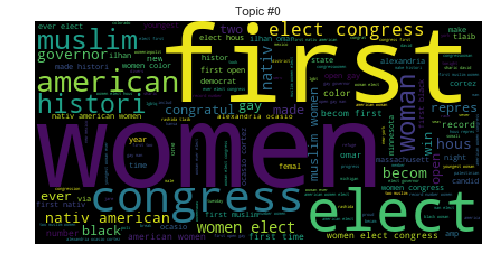

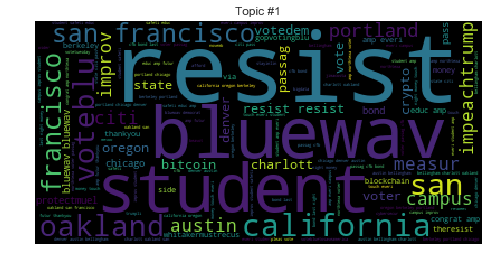

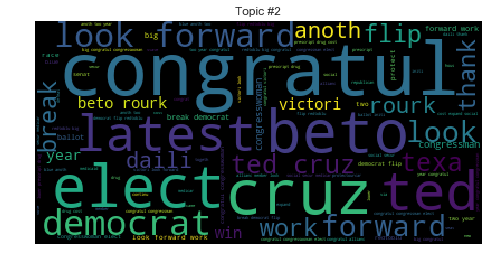

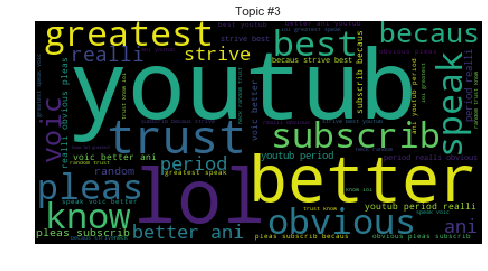

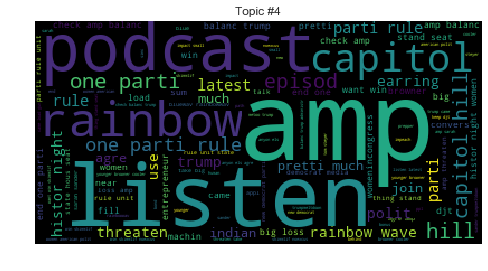

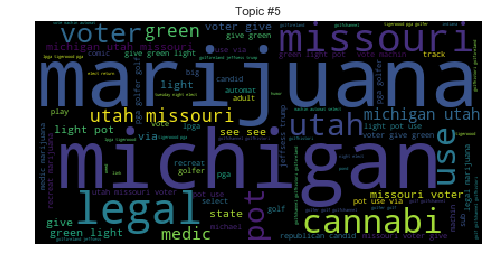

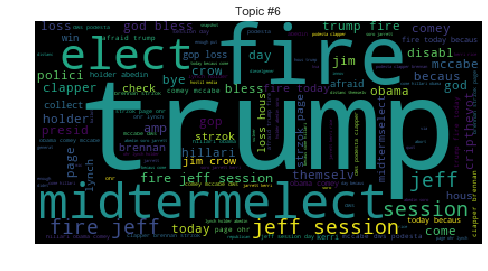

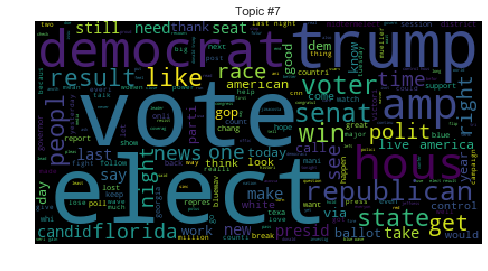

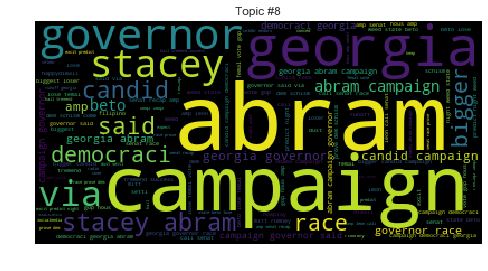

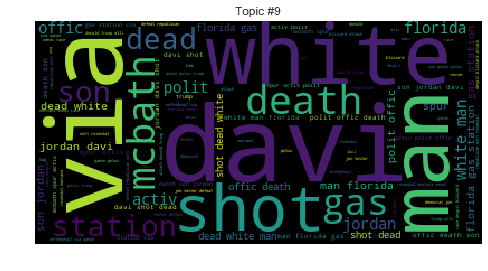

In [391]:
#word cloud for each topic
for topic in range(10):
    plt.figure(figsize = (8,10))
    plt.imshow(WordCloud().fit_words(dict(get_word_freq(topic, all_lda, 200, vocab))))
    plt.axis('off')
    plt.title('Topic #' + str(topic))
    plt.show();

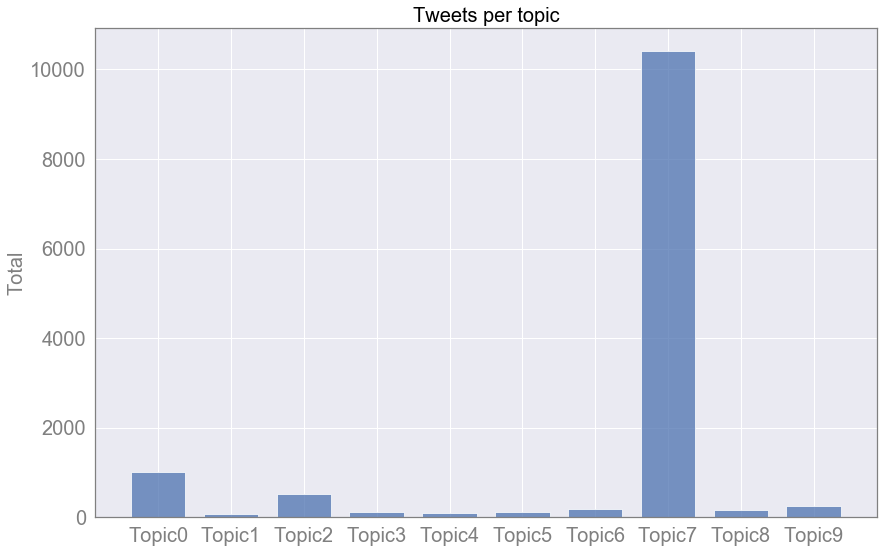

In [368]:
# Setting the positions and width for the bars
pos = list(range(10)) 
width = 0.75 
    
# Plotting the bars
fig, ax = plt.subplots(figsize=(14,9))
# Create a bar with pre_score data,
# in position pos,

plt.bar(pos, 
        #using df['pre_score'] data,
        clean_df.groupby('topic_LDA')['Polarity'].count(), 
        # of width
        width, 
        # with alpha 0.75
        alpha=0.75,  
        # with label the first value in first_name
        label=["Topic" + str(i) for i in range(all_lda.n_components)])

# Set the y axis label
ax.set_ylabel('Total')

# Set the chart's title
ax.set_title('Tweets per topic')

# Set the position of the x ticks
ax.set_xticks([p for p in pos])

# Set the labels for the x ticks
ax.set_xticklabels(["Topic" + str(i) for i in range(all_lda.n_components)])

# Setting the x-axis and y-axis limits
#plt.xlim(min(pos)-width, max(pos)+width*4)

ax.spines['bottom'].set_color('gray')
ax.spines['top'].set_color('gray')
ax.spines['right'].set_color('gray')
ax.spines['left'].set_color('gray')
ax.xaxis.label.set_color('gray')



ax.tick_params(axis='x', colors='gray')
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)
    item.set_color('gray')
    
ax.title.set_color('black')

plt.savefig('tweets_per_topic', bbox_inches = 'tight')
plt.show()

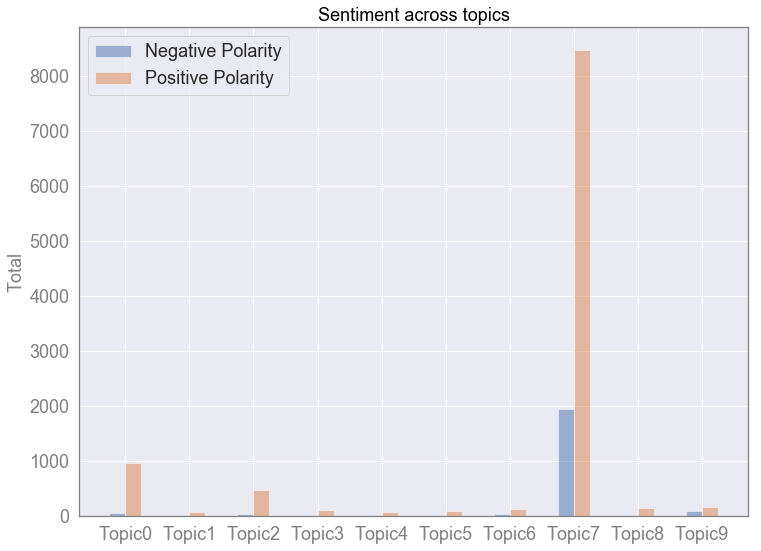

In [401]:
# Setting the positions and width for the bars
pos = list(range(10)) 
width = 0.25 
    
# Plotting the bars
fig, ax = plt.subplots(figsize=(12,9))
# Create a bar with pre_score data,
# in position pos,
plt.bar(pos, 
        #using df['pre_score'] data,
        clean_df[clean_df.Polarity < 0].groupby('topic_LDA')['Polarity'].count(), 
        # of width
        width, 
        # with alpha 0.5
        alpha=0.5,  
        # with label the first value in first_name
        label=["Topic" + str(i) for i in range(all_lda.n_components)])

plt.bar([p + width for p in pos], 
        #using df['pre_score'] data,
        clean_df[clean_df.Polarity >= 0].groupby('topic_LDA')['Polarity'].count(), 
        # of width
        width, 
        # with alpha 0.5
        alpha=0.5, 
        # with color
        #color='#FFC222', 
        # with label the first value in first_name
        label=["Topic" + str(i) for i in range(all_lda.n_components)])

# Set the y axis label
ax.set_ylabel('Total')

# Set the chart's title
ax.set_title('Sentiment across topics')

# Set the position of the x ticks
ax.set_xticks([p + 0.5 * width for p in pos])

# Set the labels for the x ticks
ax.set_xticklabels(["Topic" + str(i) for i in range(all_lda.n_components)])

# Setting the x-axis and y-axis limits
#plt.xlim(min(pos)-width, max(pos)+width*4)

ax.spines['bottom'].set_color('gray')
ax.spines['top'].set_color('gray')
ax.spines['right'].set_color('gray')
ax.spines['left'].set_color('gray')
ax.xaxis.label.set_color('gray')



ax.tick_params(axis='x', colors='gray')
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(18)
    item.set_color('gray')
    
ax.title.set_color('black')

# Adding the legend and showing the plot
plt.legend(['Negative Polarity', 'Positive Polarity'], loc='upper left', fontsize = 18)
plt.savefig('polarity')

plt.show()

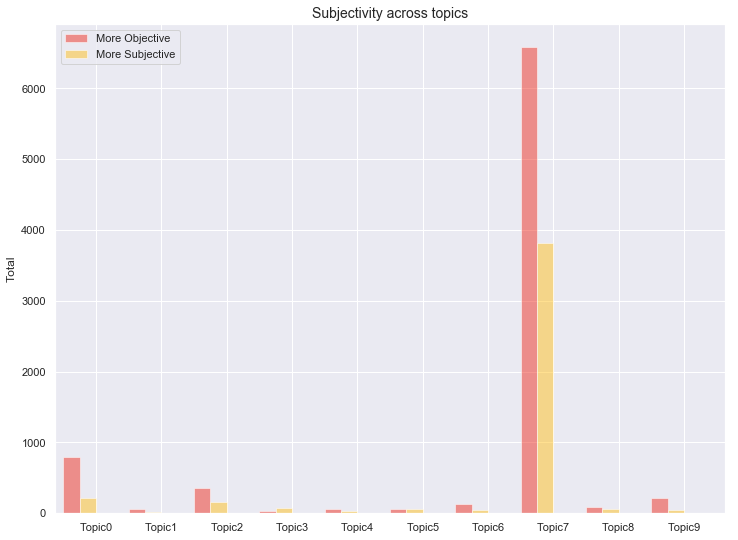

In [402]:
# Setting the positions and width for the bars
pos = list(range(10)) 
width = 0.25 
    
# Plotting the bars
fig, ax = plt.subplots(figsize=(12,9))
# Create a bar with pre_score data,
# in position pos,
plt.bar(pos, 
        #using df['pre_score'] data,
        clean_df[clean_df.Subjectivity < 0.5].groupby('topic_LDA')['Polarity'].count(), 
        # of width
        width, 
        # with alpha 0.5
        alpha=0.5, 
        # with color
        color='#EE3224', 
        # with label the first value in first_name
        label=["Topic" + str(i) for i in range(all_lda.n_components)])

plt.bar([p + width for p in pos], 
        #using df['pre_score'] data,
        clean_df[ clean_df.Subjectivity >= 0.5].groupby('topic_LDA')['Polarity'].count(), 
        # of width
        width, 
        # with alpha 0.5
        alpha=0.5, 
        # with color
        color='#FFC222', 
        # with label the first value in first_name
        label=["Topic" + str(i) for i in range(all_lda.n_components)])

# Set the y axis label
ax.set_ylabel('Total')

# Set the chart's title
ax.set_title('Subjectivity across topics',size=14)

# Set the position of the x ticks
ax.set_xticks([p + 1.5 * width for p in pos])

# Set the labels for the x ticks
ax.set_xticklabels(["Topic" + str(i) for i in range(all_lda.n_components)])

# Setting the x-axis and y-axis limits
plt.xlim(min(pos)-width, max(pos)+width*4)


# Adding the legend and showing the plot
plt.legend(['More Objective', 'More Subjective'], loc='upper left')
plt.savefig('sensitivity')
plt.show()

### Supervised learning using gradient boosting regressor to predict retweets

In [383]:
retweet_ct=pd.read_csv('rtc.csv')

In [385]:
concat_rtc=pd.concat([concat_df,retweet_ct['retweet_count']],axis=1)

In [386]:
concat_rtc.head()

,tweet,Polarity,Subjectivity,sentiment,topic_LDA,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,retweet_count
0,president didnt fire jeff sessions the day after midterms because he s afraid of you trump fired him today because now he s coming for you hillary obama comey mccabe dws podesta clapper brennan strzok page ohr lynch holder abedin soros jarrett kerry rice,-0.60,0.90,negative,6,0.0006,0.0006,0.0006,0.0006,0.0006,0.0006,0.9950,0.0006,0.0006,0.0006,5783
1,lucy mcbath a georgia gun control activist whose year old son jordan davis was shot dead by a white man over claims he was playing music too loudly in a car was elected to congress beating gop rep karen handel midterms,0.00,0.35,neutral,9,0.0894,0.0009,0.0009,0.0009,0.0009,0.0009,0.0009,0.0377,0.0009,0.8665,960
2,holy crap florida voter films browardcounty election officials transferring ballots in rented truck on election night video voterfraud rednationrising maga kag midterms,-0.80,0.80,negative,5,0.0013,0.0013,0.0013,0.0013,0.0013,0.5346,0.0013,0.4550,0.0013,0.0013,7
3,an observation midterms arizona florida georgia montana lots of suddenly found votes almost always overwhelmingly democrat votes shades of newhampshire i m beginning to suspect that this may not be by accident,0.25,0.75,positive,7,0.0022,0.0022,0.0022,0.0022,0.0022,0.0022,0.0022,0.9800,0.0022,0.0022,179
4,chads getting bigger stealingelections midterms,0.00,0.50,neutral,8,0.0111,0.0111,0.0111,0.0111,0.0111,0.0111,0.0111,0.2416,0.6695,0.0111,0


In [390]:
concat_rtc[concat_rtc['retweet_count']==   6229 ]

,tweet,Polarity,Subjectivity,sentiment,topic_LDA,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,retweet_count
598,fbi clears michael flynn in probe linking him to russia it was all a big fat lie a coup against the president that continues to this very day midterms save us from these fascists,0.1,0.2,positive,5,0.001,0.001,0.001,0.001,0.001,0.9907,0.001,0.001,0.001,0.001,6229


In [376]:
concat_rtc.groupby(['topic_LDA'])['retweet_count'].max()

topic_LDA
0    17030
1    1045 
2    6836 
3    671  
4    2141 
5    6229 
6    8687 
7    23170
8    752  
9    4226 
Name: retweet_count, dtype: int64

In [393]:
concat_rtc.drop(columns=['tweet','sentiment','topic_LDA'],inplace=True)

In [394]:
concat_rtc.head()

,Polarity,Subjectivity,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,retweet_count
0,-0.60,0.90,0.0006,0.0006,0.0006,0.0006,0.0006,0.0006,0.9950,0.0006,0.0006,0.0006,5783
1,0.00,0.35,0.0894,0.0009,0.0009,0.0009,0.0009,0.0009,0.0009,0.0377,0.0009,0.8665,960
2,-0.80,0.80,0.0013,0.0013,0.0013,0.0013,0.0013,0.5346,0.0013,0.4550,0.0013,0.0013,7
3,0.25,0.75,0.0022,0.0022,0.0022,0.0022,0.0022,0.0022,0.0022,0.9800,0.0022,0.0022,179
4,0.00,0.50,0.0111,0.0111,0.0111,0.0111,0.0111,0.0111,0.0111,0.2416,0.6695,0.0111,0


In [395]:
concat_rtc.iloc[:,:-1].columns[0]

'Polarity'

MSE: 255862.9044
[0.29563251 0.19225578 0.12245063 0.01225551 0.04710502 0.02237068
 0.01504873 0.09545051 0.09808756 0.02672526 0.05818555 0.01443227]


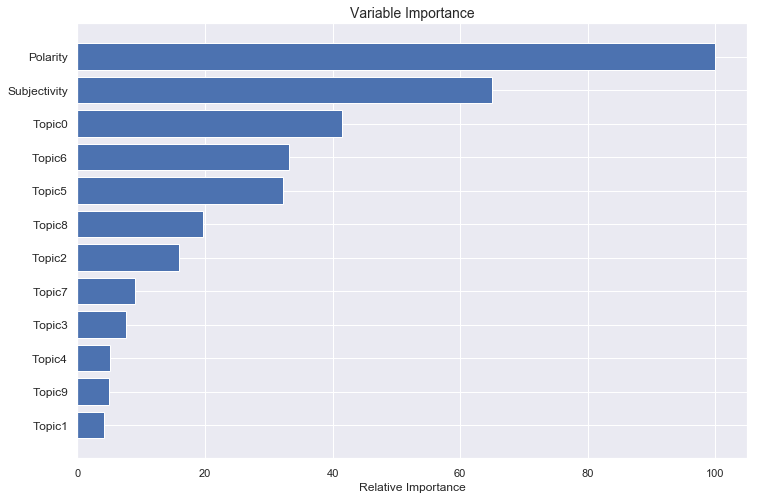

In [399]:


import numpy as np
import matplotlib.pyplot as plt

from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error


X, y = shuffle(concat_rtc.iloc[:,:-1], concat_rtc.retweet_count, random_state=13)
#X = X.astype(np.float32)
offset = int(X.shape[0] * 0.9)
X_train, y_train = X[:offset], y[:offset]
X_test, y_test = X[offset:], y[offset:]


# Fit regression model
params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
clf = ensemble.GradientBoostingRegressor(**params)

clf.fit(X_train, y_train)
mse = mean_squared_error(y_test, clf.predict(X_test))
print("MSE: %.4f" % mse)


# Plot training deviance

# compute test set deviance
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_predict(X_test)):
    test_score[i] = clf.loss_(y_test, y_pred)

plt.figure(figsize=(12, 8))
e
feature_importance = clf.feature_importances_
# make importances relative to max importance
print(feature_importance)
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, concat_rtc.iloc[:,:-1].columns[sorted_idx],size=12)
plt.xlabel('Relative Importance',size=12)
plt.title('Variable Importance',size=14)
plt.show()

In [407]:
# the most important topics acoording are topic 0, topic 6, topic5

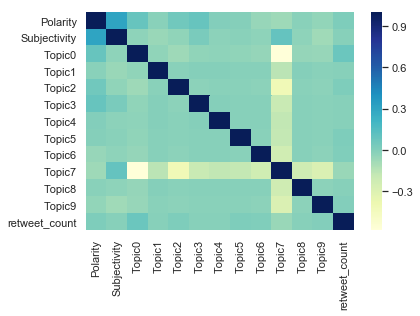

In [420]:
sns.heatmap(concat_rtc.corr(),  cmap="YlGnBu")#all features are positively correlated to retweet_count